# Init

**TODO**

1. Refactor and clean code
1. Single method for construction of network
1. Record experiment with wandb
1. bayesian optimization of hyperparameters
1. better richer data

**TODO Record Better Data**
1. record data generation parameter (basically from which distribution the data comes from)
1. record actual parameters
1. record actual data
1. data artifacts
1. groupings
1. save model
1. json schema for parameters and whatnot

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import numpy as np
import seaborn as sns
import pylab as plt

%matplotlib inline

In [3]:
# import wandb
# wandb.init(project="circuit-seq")

# Data Generation

We define a basic function, the `sigmoid` for simulating a chemical reaction network.

## Utilities

### Make Deterministic

In [4]:
import random
import torch
import numpy

SEED=0

def make_deterministic(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Visualization Tools

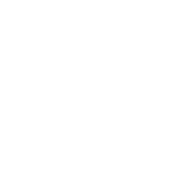

In [5]:

import collections
import numpy as np
import networkx as nx
import pylab as plt
%matplotlib inline

def sorted_center(iterable, reverse=False, key=None, select=None):
    centered = []
    s = sorted(iterable, key=key, reverse=reverse)
    front = False
    for v in s:
        if not front:
            centered.append(v)
        else:
            centered.insert(0, v)
        front = not front
    if select:
        return [select(_x) for _x in centered]
    return centered

class GraphPlotter(object):
  
  def __init__(self, graph, ax=None, pos=None):
    if ax is None:
      ax = plt.figure(figsize=(3,3)).gca()
      ax.axis('off')
      ax.set_xlim(0, 1.0)
      ax.set_ylim(0, 1.0)
    
    self._ax = ax
    self._graph = graph
    if pos is None:
      self._pos = dict()
      self.spring_layout()
    else:
      self._pos = pos
      
  @property
  def _base_draw_kwargs(self):
    return dict(G=self._graph, ax=self._ax, pos=self._pos)
 
  def topological_sort(self):
    xlim = self._ax.get_xlim()
    ylim = self._ax.get_ylim()
    
    x = xlim[1] - xlim[0]
    y = ylim[1] - ylim[0]
    xspacer = x * 0.05
    yspacer = y * 0.05
    
    new_xlim = (xlim[0] + xspacer, xlim[1] - xspacer)
    new_ylim = (ylim[0] + yspacer, ylim[1] - yspacer)
    pos = self._topological_sort(self._graph, 
                                 xlim=new_xlim, 
                                 ylim=new_ylim)
    self._pos = pos

  @staticmethod
  def _roots_and_leaves(G, include_cycles=False):
    roots = [k for k, v in G.in_degree(G.nodes) if v == 0]
    leaves = [k for k, v in G.out_degree(G.nodes) if v == 0]
    
    if include_cycles:
      for c in nx.simple_cycles(G):
        outdegree = list(G.out_degree(c))
        outdegree.sort(key=lambda x: x[1])
        leaves.append(outdegree[0][0])

        indegree = list(G.out_degree(c))
        indegree.sort(key=lambda x: x[1])
        roots.append(indegree[0][0])
    return roots, leaves
  
  @classmethod
  def _get_roots(cls, G, include_cycles=False):
    return cls._roots_and_leaves(G, include_cycles=include_cycles)[0]

  @staticmethod
  def _get_leaves(G, include_cycles=False):
    return cls._roots_and_leaves(G, include_cycles=include_cycles)[1]

  @staticmethod
  def _get_subgraphs(graph):
    """Get independent subgraphs"""
    node_list = list(graph.nodes)
    subgraphs = []
    while len(node_list) > 0:
        node = node_list[-1]
        subgraph = nx.bfs_tree(to_undirected(graph), node)
        for n in subgraph.nodes:
            node_list.remove(n)
        subgraphs.append(graph.subgraph(subgraph.nodes))
    return subgraphs

  @classmethod
  def _topological_sort(cls, G, xlim=None, ylim=None):
    if xlim is None:
        xlim = [0.05, 0.95]
    if ylim is None:
        ylim = [0.05, 0.95]
    
    rts = cls._get_roots(G, include_cycles=True)
    max_depth = {}
    for root in rts:
        depths = nx.single_source_shortest_path_length(G, root)
        for n, d in depths.items():
            max_depth[n] = max(max_depth.get(n, d), d)

    by_depth = collections.OrderedDict()

    for node, depth in max_depth.items():
        by_depth.setdefault(depth, [])
        by_depth[depth].append(node)
    
    # center nodes with highest degree
    for depth, nodes in by_depth.items():
        centered = sorted_center(list(G.degree(nodes)), 
                                 key=lambda x: x[1], 
                                 reverse=True,
                                select=lambda x: x[0])
        by_depth[depth] = centered

    # push roots 'up' so they are not stuck on layer one
    for root in rts:
        successors = list(G.successors(root))
        if len(successors) > 0:
            min_depth = min([max_depth[s] for s in successors])
            max_depth[root] = min_depth - 1

    # assign positions

    y_min_max = xlim
    x_min_max = ylim
    max_width = max([len(layer) for layer in by_depth.values()])

    y_step = (y_min_max[1] - y_min_max[0]) / (max(by_depth.keys())+1)
    x_step = (x_min_max[1] - x_min_max[0]) / (max_width )
    positions = {}

    for depth in sorted(by_depth):
        y = y_step * depth + y_min_max[0]
        node_ids = by_depth[depth]
        w = len(node_ids)
        delta_w = max_width - w
        for i, n in enumerate(node_ids):
            x_offset = delta_w * x_step / 2.0
            x = x_min_max[0] + x_offset + i * x_step
            positions[n] = (x, y)
    return positions

  def spring_layout(self, **kwargs):
    pos = nx.spring_layout(self._graph, **kwargs)
    self._pos.update(pos)
    return self._pos
    
  @property
  def nodes(self):
    return self._graph.nodes
  
  @property
  def edges(self):
    return self._graph.edges
  
  def node_attrs(self):
    keys = set()
    for _, node_data in self._graph.nodes(data=True):
      keys.update(set(node_data.keys()))
    attrs = {}
    for _, node_data in self._graph.nodes(data=True):
      for k in keys:
        attrs.setdefault(k, list())
        attrs[k].append(node_data.get(k, None))
    return attrs
  
  def edge_attrs(self):
    keys = set()
    for _, _, edge_data in self._graph.edges(data=True):
      keys.update(set(edge_data.keys()))
    attrs = {}
    for _, _, edge_data in self._graph.edges(data=True):
      for k in keys:
        attrs.setdefault(k, list())
        attrs[k].append(edge_data.get(k, None))
    return attrs
  
  def map_edge_attrs(self, attrs, source, target):
    vals = [self._normalize(self.edge_attrs()[attr], source, target) for attr in attrs]
    return dict(zip(attrs, vals))
  
  def map_node_attrs(self, attrs, source, target):
    vals = [self._normalize(self.node_attrs()[attr], source, target) for attr in attrs]
    return dict(zip(attrs, vals))
  
  def _normalize(arr, source, target):
    x = source[1] - source[0]
    y = target[1] - target[0]
    return [_x/x * y + target[0] for _x in arr] 
  
  def _make_draw_kwargs(self, **kwargs):
    kwargs.update(self._base_draw_kwargs)
    return kwargs
  
  def _draw(self, draw_function, zorder=None, **kwargs):
    draw_kwargs = self._make_draw_kwargs(**kwargs)
    collection = draw_function(**draw_kwargs)
    if collection is not None and zorder is not None:
      try:
        # This is for compatibility with older matplotlib.
        collection.set_zorder(zorder)
      except AttributeError:
        # This is for compatibility with newer matplotlib.
        collection[0].set_zorder(zorder)
    return collection

  def draw_nodes(self, **kwargs):
    """Useful kwargs: nodelist, node_size, node_color, linewidths."""
    if ("node_color" in kwargs and
        isinstance(kwargs["node_color"], collections.Sequence) and
        len(kwargs["node_color"]) in {3, 4} and
        not isinstance(kwargs["node_color"][0],
                       (collections.Sequence, np.ndarray))):
      num_nodes = len(kwargs.get("nodelist", self.nodes))
      kwargs["node_color"] = np.tile(
          np.array(kwargs["node_color"])[None], [num_nodes, 1])
    return self._draw(nx.draw_networkx_nodes, **kwargs)

  def draw_edges(self, **kwargs):
    """Useful kwargs: edgelist, width."""
    return self._draw(nx.draw_networkx_edges, **kwargs)
  
  def draw_graph(self,
                 node_size=200,
                 node_color=(0.4, 0.8, 0.4),
                 node_linewidth=1.0,
                 edge_width=1.0):
    
    node_border_color = (0.0, 0.0, 0.0, 1.0)
    
    # Plot nodes.
    self.draw_nodes(
        nodelist=self.nodes,
        node_size=node_size,
        node_color=node_color,
        linewidths=node_linewidth,
        edgecolors=node_border_color,
        zorder=20)
    # Plot edges.
    self.draw_edges(edgelist=self.edges, width=edge_width, zorder=10)

  
  
g = nx.balanced_tree(2, 2)
g = nx.to_directed(g)

for e in g.edges:
  g.edges[e[0], e[1]]['weight'] = 1
  
ax = plt.figure(figsize=(3,3)).gca()
ax.axis('off')
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
    
plotter = GraphPlotter(g, ax=ax)
plotter.topological_sort()

# plotter.draw_graph(node_color=(0, 0, 0), edge_width=plotter.edge_attrs()['weight'])

In [6]:
def plot_example_graphs(graphs, rows=4, cols=4, figsize=(10, 10)):    
    import matplotlib as mplt

    norm = mplt.colors.Normalize(0, 20)

    fig, axes = plt.subplots(rows, cols, squeeze=False, figsize=figsize)

    def flatten(x):
        arr = []
        for a in x:
            for b in a:
                arr.append(b)
        return arr

    axes = flatten(axes)
    for g, ax in zip(graphs, axes):
        if not g.number_of_nodes():
            continue
        ylabels = {n: ndata for n, ndata in g.nodes(data='y')}
        nodelist, nodedata = zip(*g.nodes(data=True))
        ylabels = {n: round(ndata['y'].flatten().item(), 2) for n, ndata in zip(nodelist, nodedata)}
        y = [round(ndata['y'].flatten().item(), 2) for ndata in nodedata]

        pos = GraphPlotter._topological_sort(g)
        nx.draw_networkx_labels(g, pos, labels=ylabels, ax=ax)
        nx.draw_networkx_nodes(g, pos, ax=ax, node_color=mplt.cm.coolwarm(norm(y)))
        nx.draw_networkx_edges(g, pos, ax=ax);
    return fig, axes

### CircuitGenerator

In [7]:
import networkx as nx
import numpy as np
import torch
from itertools import permutations
from functools import partial
from typing import Tuple, Hashable, List
import itertools
from tqdm.auto import tqdm


def has_cycle(g: nx.DiGraph) -> bool:
    try:
        nx.find_cycle(g)
        return True
    except nx.NetworkXNoCycle:
        return False


def to_one_hot(arr: torch.tensor, mx: int):
    oh = torch.zeros((arr.shape[0], mx))
    for i, a in enumerate(arr):
        oh[i, a] = 1.0
    return oh


def sigmoid(x, a, kd, n, offset, inv):
    return a - (a) / (1. + np.exp((-x + kd) * n * inv)) + offset

# class Augment:
#     @staticmethod
#     def add_all_edges(g):
#         nodes = list(g.nodes())
#         for n1, n2 in itertools.product(nodes, repeat=2):
#             if n2 not in g[n1] or g[n1][n2] is None or len(g[n1][n2]) == 0:
#                 g.add_edge(n1, n2, features=torch.tensor([0.]), target=torch.tensor([0.]))
#         return g

# TODO: record data generation parameters
# TODO: record actual parameters
# TODO: record actual data
class CircuitGenerator(object):

    functions = {
        'sigmoid': sigmoid
    }

    def __init__(self, n_parts: int):
        self.n_parts = n_parts
        self.func_name = 'sigmoid'
        assert self.func_name in self.functions
        params, labels = self.random_params(self.n_parts)
        self.params = params
        self.param_labels = params
#         self.func_params = {
#             'A': {
#                 'min': 19,
#                 'max': 20,
#                 'distribution': 'uniform'
#             },
#             'K': {
#                 'min': 19,
#                 'max': 20,
#                 'distribution': 'uniform'
#             },
#             'n': {
#                 'min': 1.9,
#                 'max': 2.,
#                 'distribution': 'uniform'
#             },
#             'o': {
#                 'min': 0,
#                 'max': 'A.max() / 10.'
#             }
#         }

    @property
    def func(self):
        return self.functions[self.func_name]

    def random_params(self, num):
        A = np.random.uniform(19, 20, size=(num))
        K = np.random.uniform(1, 2, size=(num))
        n = np.random.uniform(1.9, 2, size=(num))
        o = np.random.uniform(0, A.max() / 10., size=(num))

        A = np.expand_dims(A, 1)
        K = np.expand_dims(K, 1)
        n = np.expand_dims(n, 1)
        o = np.expand_dims(o, 1)

        # choose repressor (1) or activator (-1)
        i = np.random.choice([1], (num, 1))

        # [n_parts, n_params]
        params = np.hstack([A, K, n, o, i])
        labels = np.array(['A', 'K', 'n', 'o', 'i'])
        return params, labels

    def steady_state(self, g, acc='sum', node_to_part=lambda x: int(x)):
        acc_dict = {
            'sum': lambda x: np.sum(np.concatenate(x))
        }

        # in topological order, we evaluate the sigmoid function at each node
        for node in nx.topological_sort(g):

            idx = node_to_part(node)
            # gather all parents
            # accumulate outputs 'y' using the provided accumulation function
            parents = list(g.predecessors(node))
            if not parents:
                p = np.expand_dims(self.params[idx:idx + 1].T, 2)
                x = np.array([[0.]])
            else:
                a = []
                for p in parents:
                    _x = g.nodes[p]['y']
                    a.append(_x)
                if len(a) and len(a[0]):
                    x = acc_dict[acc](a)
                    x = x.reshape(_x.shape)
                else:
                    x = torch.tensor([], dtype=torch.float)
            y = self._partial_func(self.func_name, x, idx)
            g.nodes[node]['y'] = y

    def _partial_func(self, fname, x, node: Hashable):
        return self.functions[fname](x, *tuple(np.expand_dims(self.params[node:node + 1].T, 2)))

    def annotate_graph_with_features(self, g: nx.DiGraph, include_target: bool = True):
        # one-hot encode the graph nodes
        one_hot_encoded = to_one_hot(torch.arange(0, self.n_parts), self.n_parts)

        new_g = nx.DiGraph()
        for n, data in g.nodes(data=True):
            new_g.add_node(n, **data)
        for n1, n2, edata in g.edges(data=True):
            edata['features'] = np.array([0.])
            if include_target:
                edata['target'] = np.array([1.])
            new_g.add_edge(n1, n2, **edata)
        if include_target:
            self.steady_state(new_g, node_to_part=lambda x: x[-1])
        for n, ndata in new_g.nodes(data=True):
            # convert this to ONE HOT!
            ndata['features'] = one_hot_encoded[list(n)[-1]]
            if include_target:
                ndata['target'] = torch.tensor([ndata['y'].flatten()], dtype=torch.float)
        new_g.data = {
            'features': torch.tensor([0])
        }
        if include_target:
            new_g.data['target'] = torch.tensor([0])

        return new_g

    @staticmethod
    def graph_from_nodes(nodes: List[Tuple[Hashable, Hashable, Hashable]]) -> nx.DiGraph:
        g = nx.DiGraph()
        for n1, n2 in permutations(nodes, r=2):
            if n1[-1] in (n2[0], n2[1]):
                g.add_edge(tuple(n1), tuple(n2))
        return g

    def random_circuit(self, part_range: Tuple[int, int]):
        num_nodes = np.random.randint(*part_range)
        nodes = np.random.randint(0, self.n_parts, size=(num_nodes, 3))
        g = self.graph_from_nodes(nodes)
        return g

    def iter_random_circuit(self, limit: int, part_range: Tuple[int, int], cycles: bool = True, annotate: bool = False) -> nx.DiGraph:
        new_circuit = partial(self.random_circuit, part_range=part_range)
        for i in range(limit):
            c = new_circuit()
            if cycles is True:
                pass
            else:
                while has_cycle(c):
                    c = new_circuit()
            if annotate:
                c = self.annotate_graph_with_features(c)
            yield c


(<Figure size 720x720 with 1 Axes>,
 [<matplotlib.axes._subplots.AxesSubplot at 0x7ff43e777610>])

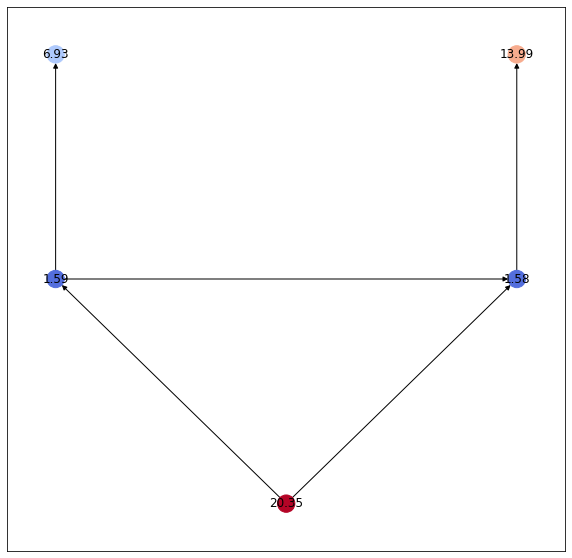

In [8]:
make_deterministic(5)
g = CircuitGenerator.graph_from_nodes(
    [
(2, 5, 16), (16, 3, 8), (4, 16, 3), (8, 1, 17), (7, 3, 18)
    ]
)
gen = CircuitGenerator(22)
                       
g = gen.annotate_graph_with_features(g)
plot_example_graphs([g], rows=1, cols=1)

#### Create Circuits

TODO: Save data generation parameters (function, part range, number of parts, parameters, number of graphs)

TODO: Save graphs as `.h5` file

## Data Generators

In [9]:
import random
import torch
import numpy
from pyrographnets.data import *
def split(arr, x):
    assert x > 0 and x <= 1
    i = int(len(arr)*x)
    j = len(arr) - i
    return arr[:i], arr[j:]

# test circuit generation process
make_deterministic(0)
generator = CircuitGenerator(20)

# new data
# ability to generalize larger circuits
def generate_data(train_size, train_part_range, devtest_size, devtest_part_range, train__train_dev_split=0.9, dev_test_split=0.5):
    # training distribution
    training_distribution = list(generator.iter_random_circuit(train_size, train_part_range, cycles=False, annotate=True))
    train_graphs, train_dev_graphs = split(training_distribution, train__train_dev_split)

    # dev/test distribution
    test_dev_distribution = list(generator.iter_random_circuit(devtest_size, devtest_part_range, cycles=False, annotate=True))
    dev_graphs, test_graphs = split(test_dev_distribution, dev_test_split)
    return {
        'train': train_graphs,
        'train/dev': train_dev_graphs,
        'dev': dev_graphs,
        'test': test_graphs
    }
# augmenting edges results in loss of learning ability
# [Augment.add_all_edges(g) for g in tqdm(graphs)]

def create_loader(graphs, batch_size, shuffle):
    train_batch = GraphBatch.from_networkx_list(graphs, n_edge_feat=1, n_node_feat=generator.n_parts, n_glob_feat=1)
    target_batch = GraphBatch.from_networkx_list(graphs, n_edge_feat=16, n_node_feat=1, n_glob_feat=1, feature_key='target')
    train_list = train_batch.to_data_list()
    target_list = target_batch.to_data_list()
    if batch_size is None:
        batch_size = len(train_list)
    return GraphDataLoader(list(zip(train_list, target_list)), batch_size=batch_size, shuffle=shuffle)
  
    
data = generate_data(1000, (2, 6), 2000, (2, 8))
train_loader = create_loader(data["train"], 512, shuffle=True)
eval_loader = create_loader(data["train/dev"], None, shuffle=False)

for a, b in eval_loader:
    pass
assert a

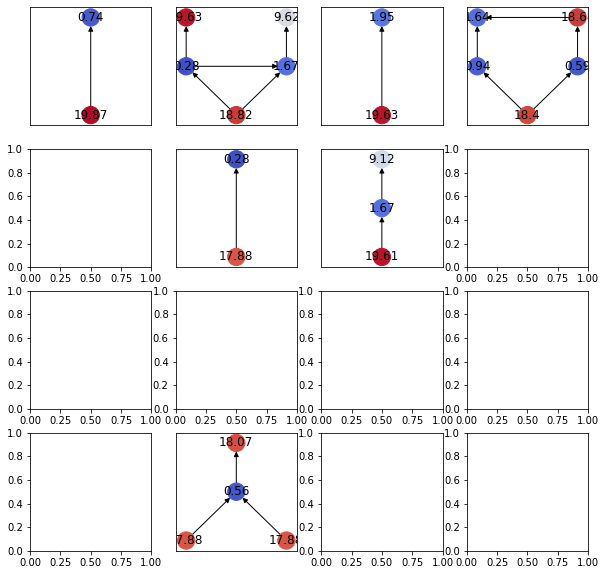

In [10]:
plot_example_graphs(data['train'][10:]);

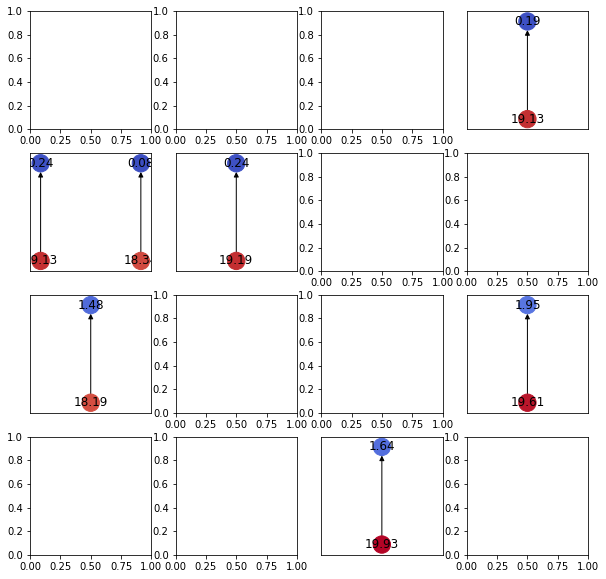

In [11]:
plot_example_graphs(data['train/dev']);

#### Check Data Generation Process

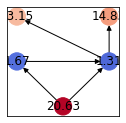

(2, 3, 12)
[[13.15039918]]
(3, 2, 11)
[[14.82716832]]
(8, 13, 2)
[[1.31027426]]
(8, 19, 8)
[[1.67284495]]
(13, 16, 8)
[[20.63364515]]
(array([12]),)
(array([11]),)
(array([2]),)
(array([8]),)
(array([8]),)


tensor([[13.1504],
        [14.8272],
        [ 1.3103],
        [ 1.6728],
        [20.6336]])

In [12]:
index = 'not and index'
g1 = None

for i, g in enumerate(data['train']):
    if g.number_of_nodes() > 4:
        g1 = g
        index = i
        break
g1 = data['train'][index]
g1
plot_example_graphs([g1], rows=1, cols=1, figsize=(2, 2))
plt.show()

gbatch = GraphBatch.from_networkx_list([g1], n_edge_feat=1, n_node_feat=generator.n_parts, n_glob_feat=1)
for n in sorted(g1.nodes()):
    print(n)
    print(g1.nodes[n]['y'])
for _x in gbatch.x:
    print(np.where(_x == 1))
    
inspect_loader = list(create_loader([g1], 1, False))
inspect_loader[0][1].x

In [13]:
inspect_loader = list(create_loader([g1], 1, False))

In [14]:
inspect_loader[0][0].x

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])

In [15]:
inspect_loader[0][1].x

tensor([[13.1504],
        [14.8272],
        [ 1.3103],
        [ 1.6728],
        [20.6336]])

# Model

## MLP

In [16]:
from typing import List

from torch import nn

from pyrographnets.utils import pairwise

class MLPBlock(nn.Module):
    """A multilayer perceptron block."""

    def __init__(self, input_size: int, output_size: int = None):
        super().__init__()
        if output_size is None:
            output_size = input_size
        self.blocks = nn.Sequential(
            nn.Linear(input_size, output_size), nn.ReLU(), nn.LayerNorm(output_size)
        )

    def forward(self, x):
        return self.blocks(x)


class MLP(nn.Module):
    """A multilayer perceptron."""

    def __init__(self, *latent_sizes: List[int]):
        super().__init__()
        self.blocks = nn.Sequential(
            *[MLPBlock(n1, n2) for n1, n2 in pairwise(latent_sizes)]
        )

    def forward(self, x):
        return self.blocks(x)

## Network

In [17]:
from pyrographnets.models import GraphEncoder, GraphCore
from pyrographnets.blocks import EdgeBlock, NodeBlock, GlobalBlock, AggregatingEdgeBlock, AggregatingGlobalBlock, AggregatingNodeBlock, Aggregator
from pyrographnets.blocks import Flex
from pyrographnets.blocks import MLP

class Network(torch.nn.Module):
    
    def __init__(self, latent_sizes=(128, 128, 1), 
                 depths=(1, 1, 1),
                 pass_global_to_edge: bool = True, 
                 pass_global_to_node: bool = True):  
        super().__init__()
        self.config = {
            'latent_size': {
                'node': latent_sizes[1],
                'edge': latent_sizes[0],
                'global': latent_sizes[2],
                'core_node_block_depth': depths[0],
                'core_edge_block_depth': depths[1],
                'core_global_block_depth': depths[2]
            },
            'node_block_aggregator': 'add',
            'global_block_to_node_aggregator': 'add',
            'global_block_to_edge_aggregator': 'add',
            'pass_global_to_edge': pass_global_to_edge,
            'pass_global_to_node': pass_global_to_node
        }
        self.encoder = GraphEncoder(
            EdgeBlock(Flex(MLP)(Flex.d(), latent_sizes[0])),
            NodeBlock(Flex(MLP)(Flex.d(), latent_sizes[1])),
            GlobalBlock(Flex(MLP)(Flex.d(), latent_sizes[2]))
        )
        
        edge_layers = [self.config['latent_size']['edge']]*self.config['latent_size']['core_edge_block_depth']
        node_layers = [self.config['latent_size']['node']]*self.config['latent_size']['core_node_block_depth']
        global_layers = [self.config['latent_size']['global']]*self.config['latent_size']['core_global_block_depth']
        
        self.core = GraphCore(
            AggregatingEdgeBlock(torch.nn.Sequential(
                Flex(MLP)(Flex.d(), *edge_layers),
#                 torch.nn.Linear(latent_sizes[0], latent_sizes[0])
            )),
            AggregatingNodeBlock(torch.nn.Sequential(
                Flex(MLP)(Flex.d(), *node_layers),
#                 torch.nn.Linear(latent_sizes[1], latent_sizes[1])
            ), Aggregator(self.config['node_block_aggregator'])),
            AggregatingGlobalBlock(Flex(MLP)(Flex.d(), *global_layers), 
                                   edge_aggregator=Aggregator(self.config['global_block_to_edge_aggregator']), 
                                   node_aggregator=Aggregator(self.config['global_block_to_node_aggregator'])),
            pass_global_to_edge=self.config['pass_global_to_edge'],
            pass_global_to_node=self.config['pass_global_to_node']
        )
        
        self.decoder = GraphEncoder(
            EdgeBlock(Flex(MLP)(   Flex.d(),   latent_sizes[0], latent_sizes[0])),
            NodeBlock(Flex(MLP)(   Flex.d(),   latent_sizes[1], latent_sizes[1])),
            GlobalBlock(Flex(MLP)( Flex.d(),   latent_sizes[2]))
        )
                
        self.output_transform = GraphEncoder(
            EdgeBlock(Flex(torch.nn.Linear)(Flex.d(), 1)),
            NodeBlock(Flex(torch.nn.Linear)(Flex.d(), 1)),
            GlobalBlock(Flex(torch.nn.Linear)(Flex.d(), 1)),
        )
        
    def forward(self, data, steps):

        # encoded
        e, x, g = self.encoder(data)
        data = GraphBatch(x, e, g, data.edges, data.node_idx, data.edge_idx)
        
        # graph topography data
        edges = data.edges
        node_idx = data.node_idx
        edge_idx = data.edge_idx
        latent0 = data
        
        meta = (edges, node_idx, edge_idx)
        
        outputs = []
        for _ in range(steps):
            # core processing step
            e = torch.cat([latent0.e, e], dim=1)
            x = torch.cat([latent0.x, x], dim=1)
            g = torch.cat([latent0.g, g], dim=1)
            data = GraphBatch(x, e, g, *meta)
            e, x, g = self.core(data)
        
            # decode 
            data = GraphBatch(x, e, g, *meta)
            
            _e, _x, _g = self.decoder(data)
            decoded = GraphBatch(_x, _e, _g, *meta)
            
            # transform
            _e, _x, _g = self.output_transform(decoded)
            outputs.append(GraphBatch(_x, _e, _g, edges, node_idx, edge_idx))
            
        # revise connectivity
        
        return outputs
        
net = Network()

for samples in train_loader:
#     print(samples[0].x.shape)
    out = net(samples[0], 10)

### Misc Blocks

In [18]:
import torch


class Select(torch.nn.Module):
    """Differentiable select block"""
    def __init__(self, input_size: int, output_size: int):
        super().__init__()
        self.blocks = torch.nn.Sequential(
            torch.nn.Linear(input_size, output_size),
            torch.nn.Sigmoid()
        )

    def forward(self, data: torch.Tensor, latent: torch.Tensor) -> torch.Tensor:
        out = self.blocks(latent)
        i = torch.where(torch.round(out) == 1)[0]
        return data[i]

class SelectIndex(torch.nn.Module):
    
    def __init__(self, input_size: int, output_size: int):
        super().__init__()
        self.blocks = torch.nn.Sequential(
            torch.nn.Linear(input_size, output_size),
            torch.nn.Sigmoid()
        )
        
    def forward(self, data: torch.Tensor) -> torch.Tensor:
        """Note the output itself is NOT differentiable"""
        out = self.blocks(data)
        return self.blocks(data)

class NewNetwork(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net1 = Network()
        self.select_index = Flex(SelectIndex)(Flex.d(), 1)
        self.net2 = Network()
        
    def forward(self, data, steps1, steps2 = None):
        if steps2 is None:
            steps2 = steps1
            
        # initial processing
        outputs = self.net1(data, steps1)
        
        # revise the edge connectivity
        i = self.select_index(outputs[-1].e)
        selected_data = GraphBatch(
            data.x,
            data.e * i,
            data.g,
            (data.edges * i.T).long(),
            data.node_idx,
            data.edge_idx
        )
        
        # repeat the processing
        return self.net2(selected_data, steps2)
    
model = NewNetwork()

for samples in train_loader:
    pass
model(samples[0], 10)

[<GraphBatch size(n,e,g)=torch.Size([563, 347, 221]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([563, 347, 221]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([563, 347, 221]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([563, 347, 221]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([563, 347, 221]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([563, 347, 221]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([563, 347, 221]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([563, 347, 221]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([563, 347, 221]) features(n,e,g)=torch.Size([1, 1, 1])>,
 <GraphBatch size(n,e,g)=torch.Size([563, 347, 221]) features(n,e,g)=torch.Size([1, 1, 1])>]

# Train Utilities

## Visualization Utilities

In [19]:
import seaborn as sns

def plot_kinetics(model, data, steps):
    
    with torch.no_grad():
        out = model(data, steps)
        x_arr = []
        for i, data in enumerate(out):
            t = torch.tensor([[i]] * data.x.shape[0], dtype=torch.float)
            index = torch.unsqueeze(torch.arange(data.x.shape[0], dtype=torch.float), 1)
            index = index.to(data.x.device)
            t = t.to(data.x.device)
            x = torch.cat([t, data.x, index], dim=1)
            x_arr.append(x)

        x = torch.cat(x_arr)
        df = pd.DataFrame({
            't': x[:, 0].detach().cpu(),
            'x': x[:, 1].detach().cpu(),
            'node': x[:, 2].detach().cpu()
        })
        df = df[df['node'] < 20]
        fig = plt.figure(figsize=(10, 10))
        ax = fig.gca()
        ax.set_ylim(-5, 20)
        sns.lineplot(x='t', y='x', hue='node', data=df, ax=ax)
        
    return ax, fig

# Train

In [20]:
def degree(graph_batch, i):
    number_of_nodes = graph_batch.x.shape[0]
    counts = torch.unique(graph_batch.edges[i], return_counts=True)[1]
    degree = torch.cat([counts, torch.zeros(number_of_nodes - counts.shape[0], dtype=torch.long)]).to(torch.float)
    return degree.mean(), degree.std()

def loader_summary(loader: GraphDataLoader):
    x = []
    e = []
    g = []
    edges = []
    indegrees = []
    outdegrees = []
    for d, _ in loader:
        number_of_nodes = d.x.shape[0]
        number_of_edges = d.e.shape[0]
        number_of_graphs = d.g.shape[0]
        
        x.append(number_of_nodes)
        e.append(number_of_edges)
        g.append(number_of_graphs)

        indegrees.append(degree(d, 1)[0])
        outdegrees.append(degree(d, 0)[0])

    x = np.array(x)
    e = np.array(e)
    g = np.array(g)
    indegrees = np.array(indegrees)
    outdegrees = np.array(outdegrees)
    
    
    info = {
        'graphs': {
            'sum': g.sum(),
            'batch_mean': g.mean(),
            'batch_std': g.std(),
            'batch_indegree_mean': indegrees.mean(),
            'batch_outdegree_mean': outdegrees.mean(),
            'batch_indegree_std': indegrees.std(),
            'batch_outdegree_std': outdegrees.std(),
        },
        'edges': {
            'sum': e.sum(),
            'batch_mean': e.mean(),
            'batch_std': e.std()
        },
        'nodes': {          
            'sum': x.sum(),
            'batch_mean': x.mean(),
            'batch_std': x.std()
        }
    }

    return info

loader_summary(train_loader)


{'graphs': {'sum': 4829,
  'batch_mean': 482.9,
  'batch_std': 87.3,
  'batch_indegree_mean': 0.60808814,
  'batch_outdegree_mean': 0.60808814,
  'batch_indegree_std': 0.006523716,
  'batch_outdegree_std': 0.006523716},
 'edges': {'sum': 7834, 'batch_mean': 783.4, 'batch_std': 144.057072023556},
 'nodes': {'sum': 12875, 'batch_mean': 1287.5, 'batch_std': 233.5398252975282}}

In [28]:
######################################################################################

import wandb
PROJECT="CircuitSeq"

notes = """
Exploring how graph deep learning models train on simulated regulatory network data.
20200808 Fixing training and data generation process
"""

wandb.init(
    project="CircuitSeq", 
    tags=['explore', 'regulatory networks', 'simulated data', 'circuitseq'],
    entity='jvrana',
    save_code=False, 
    group="explore",
    notes=notes.strip()
)

######################################################################################

from pyrographnets.utils.tensorboard import new_writer
from pyrographnets.data import GraphBatch, GraphDataLoader
from tqdm.auto import tqdm
from pyrographnets.utils import _first

device = 'cuda:0'

net = Network((254, 254, 128), (3, 3, 3), True, True)

train_loader = create_loader(data["train"], 512, shuffle=True)
eval_loader = create_loader(data["train/dev"], None, shuffle=False)

PROCESSING_STEPS = 5
wandb.config.update(net.config)
wandb.config.update({
    'processing_steps': PROCESSING_STEPS
})
wandb.config.update({
    'train': {
        'loader_summary': loader_summary(train_loader)
    },
    'eval': {
        'loader_summary': loader_summary(eval_loader)
    }
})

with torch.no_grad():
    batch, _ = _first(train_loader)
    print(batch.shape)
    out = net(batch, 3)
# print(out.x)
net.to(device)

def to(batch, device):
    return GraphBatch(
        batch.x.to(device),
        batch.e.to(device),
        batch.g.to(device),
        batch.edges.to(device),
        batch.node_idx.to(device),
        batch.edge_idx.to(device)
    )

import pandas as pd

def plot(target_data, out):
    x = target_data.x.cpu().detach().numpy().flatten()
    y = out.x.cpu().detach().numpy().flatten()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    df = pd.DataFrame({'x': x, 'y': y})
    ax = sns.scatterplot('x', 'y', data=df, ax=ax)
    ax.set_ylim(-5, 20)
    ax.set_xlim(-5, 20)
    return ax, fig

# training
make_deterministic(0)

optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = torch.nn.MSELoss()

net.train()
for epoch in tqdm(range(3000)):
    net.train()
    running_loss = 0.
    
    for batch_idx, (train_data, target_data) in enumerate(train_loader):
        train_data.contiguous()
        target_data.contiguous()
        target_data = target_data.clone()
#         target_data.x = torch.randn(*target_data.x.shape) * 0.1 + target_data.x
#             test_data = batch.mask(*test_mask)
#             target_data = batch.mask(*test_mask, invert=True)
        train_data = to(train_data, device)
        target_data = to(target_data, device)
        out = net(train_data, PROCESSING_STEPS)
        assert out[-1].x.shape == target_data.x.shape
        
        optimizer.zero_grad()
        
        # TODO: the scale of the loss is proporational to the processing steps and batch_size, should this be normalized???
        loss = torch.tensor(0.).to(device)
        for _out in out:
            loss += loss_fn(_out.x, target_data.x)
        loss = loss / (target_data.x.shape[0] * 1. * len(out))
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
    if epoch % 10 == 0:
        wandb.log({'test_loss': running_loss, 'epoch': epoch}, step=epoch)

    if epoch % 10 == 0:
        eval_loss = 0.
        net.eval()
        with torch.no_grad():
            for eval_data, eval_target in eval_loader:
                eval_data = to(eval_data, device)
                eval_target = to(eval_target, device)
                eval_outs = net(eval_data, PROCESSING_STEPS)
                # only take loss from last output
                eval_loss += loss_fn(eval_outs[-1].x, eval_target.x) / eval_outs[-1].x.shape[0]
            wandb.log({'eval loss': eval_loss / eval_data.x.shape[0] * 1000, 'epoch': epoch}, step=epoch)
    
    
    if epoch % 20 == 0:
        with torch.no_grad():
            for eval_data, eval_target in eval_loader:
                eval_data = eval_data.to(device)
                eval_target = to(eval_target, device)
            predicted = net(eval_data, PROCESSING_STEPS)[-1]
            ax, fig = plot(eval_target, predicted)
            wandb.log({'compare': fig}, step=epoch)
            
            wandb.log({
                'edge_attr': wandb.Histogram(out[-1].e.cpu()),
                'node_attr': wandb.Histogram(out[-1].x.cpu())
            }, step=epoch)


torch.Size([20, 1, 1])


KeyboardInterrupt: 

Error in callback <function _init_jupyter.<locals>.cleanup at 0x7ff3b81e7440> (for post_run_cell):


KeyboardInterrupt: 

# Model Evaluation

In [ ]:
for eval_data, eval_target in eval_loader:
    pass
predicted = net(eval_data, PROCESSING_STEPS)[-1]
ax, fig = plot(eval_target, predicted)

In [ ]:
g = from_nodes([
    (0, 0, 2),
    (2, 2, 4),
    (4, 4, 6),
    (6, 6, 8),
    (2, 10, 10)
])
g = add_features(g, False)
for n, ndata in g.nodes(data=True):
    print(ndata)
batch = GraphBatch.from_networkx_list([g])
batch = to(batch, device)

plot_kinetics(net, batch, 10)
# net(batch, 10)